In [1]:
import numpy as np
import pandas as pd
import matplotlib as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/demouser/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [3]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

In [4]:
data = pd.read_csv("household_power_consumption.txt", sep=';')

/home/demouser/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
data.loc[data["Global_active_power"] == "?", data.columns[2:]] = np.nan

In [6]:
for name in data.columns[2:]:
    data[name] = data[name].astype(float)

In [7]:
for name in data.columns[2:]:
    data[name] = data[name].fillna(data[name].mean())

In [8]:
context_length = 60
test_length = 60

In [9]:
train_length = int(len(data)*0.8)

In [10]:
cols = [name for name in data.columns[2:] if name != "Global_active_power"]

In [11]:
cols

['Global_reactive_power',
 'Voltage',
 'Global_intensity',
 'Sub_metering_1',
 'Sub_metering_2',
 'Sub_metering_3']

In [12]:
X_context = np.zeros((len(data), context_length, len(cols), 1))
X_target = np.zeros((len(data), test_length, len(cols), 1))
y_context = np.zeros((len(data), context_length, 1, 1))
y_target = np.zeros((len(data), test_length, 1, 1))

In [13]:
for i, name in enumerate(cols):
    for j in range(context_length):
        X_context[:, j, i, 0] = data[name].shift(context_length - j - 1).fillna(method='bfill')
    for k in range(test_length):
        X_target[:, k, i, 0] = data[name].shift(-k).fillna(method='ffill')

In [14]:
for j in range(context_length):
    y_context[:, j, 0, 0] = data["Global_active_power"].shift(context_length - j - 1).fillna(method='bfill')

for k in range(test_length):
    y_target[:, k, 0, 0] = data["Global_active_power"].shift(-k).fillna(method='ffill')

In [15]:
X_context = X_context[context_length:-test_length]
X_target = X_target[context_length:-test_length]

In [16]:
y_context = y_context[context_length:-test_length]
y_target = y_target[context_length:-test_length]

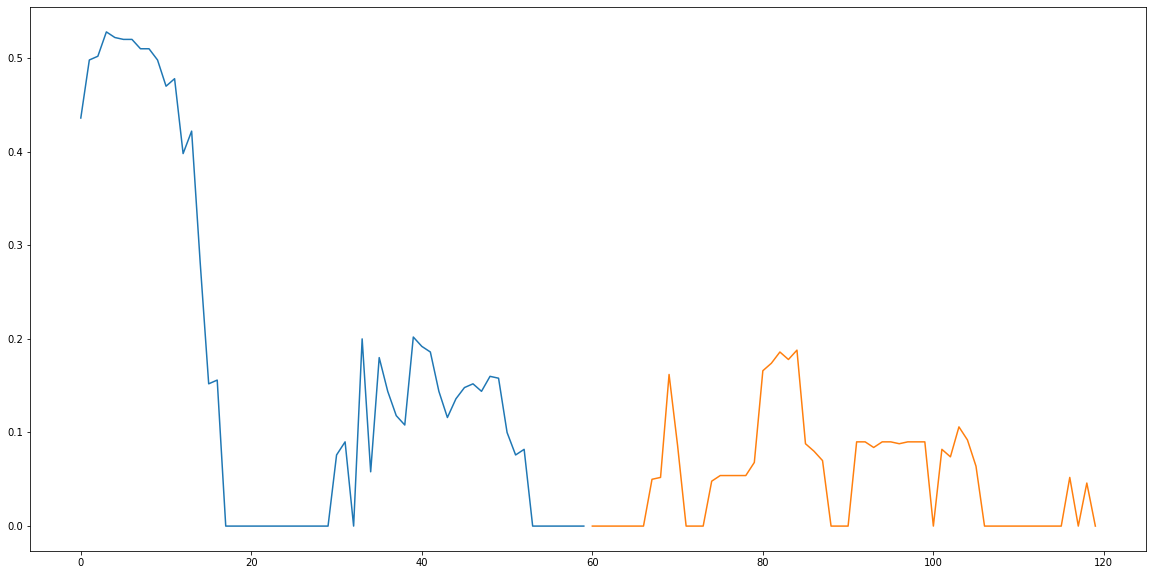

In [17]:
plt.figure(figsize=(20, 10))
plt.plot(range(context_length), X_context[0, :, 0, 0])
plt.plot(range(context_length, test_length+context_length), X_target[0, :, 0, 0])

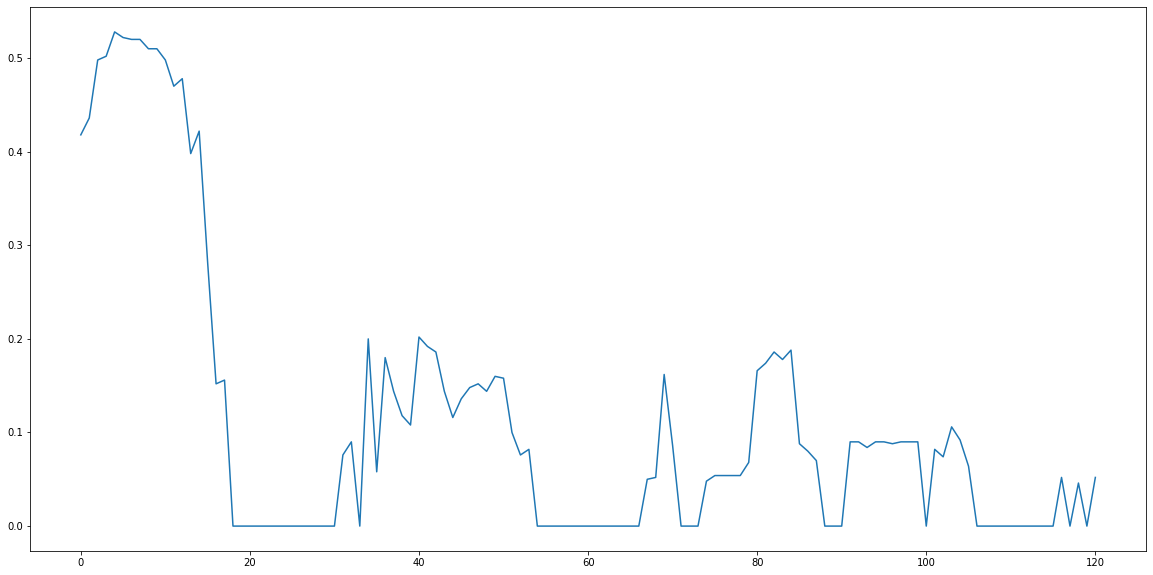

In [18]:
plt.figure(figsize=(20, 10))
plt.plot(data.loc[:context_length + test_length, cols[0]])

In [19]:
X_context_train = X_context[:train_length]
X_target_train = X_target[:train_length]
y_context_train = y_context[:train_length]
y_target_train = y_target[:train_length]

X_context_test = X_context[train_length:]
X_target_test = X_target[train_length:]
y_context_test = y_context[train_length:]
y_target_test = y_target[train_length:]

In [20]:
X_context_min = X_context_train.min(axis=0)
X_context_max = X_context_train.max(axis=0)
y_context_min = y_context_train.min(axis=0)
y_context_max = y_context_train.max(axis=0)

In [21]:
X_target_min = X_target_train.min(axis=0)
X_target_max = X_target_train.max(axis=0)
y_target_min = y_target_train.min(axis=0)
y_target_max = y_target_train.max(axis=0)

In [22]:
X_context_train = (X_context_train - X_context_min)/(X_context_max - X_context_min)
X_context_test = (X_context_test - X_context_min)/(X_context_max - X_context_min)
X_target_train = (X_target_train - X_target_min)/(X_target_max - X_target_min)
X_target_test = (X_target_test - X_target_min)/(X_target_max - X_target_min)
y_context_train = (y_context_train - y_context_min)/(y_context_max - y_context_min)
y_context_test = (y_context_test - y_context_min)/(y_context_max - y_context_min)
y_target_train = (y_target_train - y_target_min)/(y_target_max - y_target_min)
y_target_test = (y_target_test - y_target_min)/(y_target_max - y_target_min)


In [23]:
X_context_train_t = torch.Tensor(X_context_train)
X_context_test_t = torch.Tensor(X_context_test)
X_target_train_t = torch.Tensor(X_target_train)
X_target_test_t = torch.Tensor(X_target_test)

y_context_train_t = torch.Tensor(y_context_train)
y_context_test_t = torch.Tensor(y_context_test)
y_target_train_t = torch.Tensor(y_target_train)
y_target_test_t = torch.Tensor(y_target_test)

In [24]:
train_loader = DataLoader(TensorDataset(X_context_train_t, y_context_train_t, X_target_train_t, y_target_train_t),
                          shuffle=True, batch_size=256)
test_loader = DataLoader(TensorDataset(X_context_test_t, y_context_test_t, X_target_test_t, y_target_test_t),
                         shuffle=False, batch_size=256)


In [25]:
class DeterministicEncoder(nn.Module):
    def __init__(self, x_dim, y_dim, n_units, latent_dim, self_attention_type="dot", cross_attention_type="dot"):
        super().__init__()
        self.det_lstm_encoder = nn.LSTM(x_dim + y_dim, n_units, batch_first=True)
        self.k = nn.Linear(x_dim, n_units)
        self.q = nn.Linear(x_dim, n_units)
        self.self_attention = Attention(n_units, self_attention_type)
        self.cross_attention = Attention(n_units, cross_attention_type)
        self.n_units = n_units
    def forward(self, context_x, context_y, target_x):
        hs = []
        xy = torch.cat([context_x, context_y], dim=2)
        output, (h, c) = self.det_lstm_encoder(xy[..., 0])
        hs.append(output)
        for i in range(1, xy.shape[-1]):
            # keep recurrent states for next sequence
            output, (h, c) = self.det_lstm_encoder(xy[..., i], (h, c))
            hs.append(output)
        hs = torch.stack(hs)
        r = hs.mean(dim=0)
        r = self.self_attention(r, r, r)
        k = self.k(context_x.mean(dim=-1))
        q = self.q(target_x.mean(dim=-1))
        r = self.cross_attention(k, r, q)
        
        return r
        

In [26]:
class LatentEncoder(nn.Module):
    def __init__(self, x_dim, y_dim, n_units, latent_dim, self_attention_type="dot"):
        super().__init__()
        self.det_lstm_encoder = nn.LSTM(x_dim + y_dim, n_units, batch_first=True)
        self.mean_transform = nn.Linear(n_units, latent_dim)
        self.log_var_transform = nn.Linear(n_units, latent_dim)
        self.self_attention = Attention(n_units, self_attention_type)
    def forward(self, x, y, h=None, c=None):
        hs = []
        xy = torch.cat([x, y], dim=2)
        if h is None:
            output, (h, c) = self.det_lstm_encoder(xy[..., 0])
        else:
            output, (h, c) = self.det_lstm_encoder(xy[..., 0], (h, c))
        hs.append(output)
        for i in range(1, xy.shape[-1]):
            # keep recurrent states for next sequence
            output, (h, c) = self.det_lstm_encoder(xy[..., i], (h, c))
            hs.append(output)
        hs = torch.stack(hs)
        r = hs.mean(dim=0)
        r = self.self_attention(r, r, r)
        mean = self.mean_transform(r)
        log_var = self.log_var_transform(r)
        z = torch.randn_like(mean)*torch.exp(log_var/2.0) + mean
        return z, mean, log_var, h, c
        

In [27]:
class Attention(nn.Module):
    def __init__(self, hidden_dim, attention_type, n_heads=8):
        super().__init__()
        if attention_type == "uniform":
            self._attention_func = self._uniform_attention
        elif attention_type == "laplace":
            self._attention_func = self._laplace_attention
        elif attention_type == "dot":
            self._attention_func = self._dot_attention
        elif attention_type == "multihead":
            self._W_k = nn.ModuleList([nn.Linear(hidden_dim, hidden_dim) for _ in range(n_heads)])
            self._W_v = nn.ModuleList([nn.Linear(hidden_dim, hidden_dim) for _ in range(n_heads)])
            self._W_q = nn.ModuleList([nn.Linear(hidden_dim, hidden_dim) for _ in range(n_heads)])
            self._W = nn.Linear(n_heads*hidden_dim, hidden_dim)
            self._attention_func = self._multihead_attention
            self.n_heads = n_heads
        else:
            raise NotImplementedError
            
    def forward(self, k, v, q):
        rep = self._attention_func(k, v, q)
        return rep
    
    def _uniform_attention(self, k, v, q):
        total_points = q.shape[1]
        rep = torch.mean(v, dim=1, keepdim=True)
        rep = rep.repeat(1, total_points, 1)
        return rep
    
    def _laplace_attention(self, k, v, q, scale=0.5):
        k_ = k.unsqueeze(1)
        v_ = v.unsqueeze(2)
        unnorm_weights = torch.abs((k_ - v_)*scale)
        unnorm_weights = unnorm_weights.sum(dim=-1)
        weights = torch.softmax(unnorm_weights, dim=-1)
        rep = torch.einsum('bik,bkj->bij', weights, v)
        return rep
    
    def _dot_attention(self, k, v, q):
        scale = q.shape[-1]**0.5
        unnorm_weights = torch.einsum('bjk,bik->bij', k, q) / scale
        weights = torch.softmax(unnorm_weights, dim=-1)
        
        rep = torch.einsum('bik,bkj->bij', weights, v)
        return rep
    
    def _multihead_attention(self, k, v, q):
        outs = []
        for i in range(self.n_heads):
            k_ = self._W_k[i](k)
            v_ = self._W_v[i](v)
            q_ = self._W_q[i](q)
            out = self._dot_attention(k_, v_, q_)
            outs.append(out)
        outs = torch.stack(outs, dim=-1)
        outs = outs.view(outs.shape[0], outs.shape[1], -1)
        rep = self._W(outs)
        return rep

In [28]:
class Decoder(nn.Module):
    def __init__(self, x_dim, det_enc_n_units, lat_enc_latent_dim, output_dim, n_units):
        super().__init__()
        self.lstm_dec = nn.LSTMCell(x_dim + det_enc_n_units + lat_enc_latent_dim, n_units)
        self.mean_transform1 = nn.Linear(n_units, 2*n_units)
        self.mean_transform2 = nn.Linear(2*n_units, output_dim)
        self.std_transform = nn.Linear(n_units, output_dim)
        self.softplus = nn.Softplus()
        self.n_units = n_units
        self.output_dim = output_dim
    def forward(self, r, z, target_x):
        outputs = []
        
        r = r.unsqueeze(3)
        z = z.unsqueeze(3)
        
        r = r.repeat(1, 1, 1, target_x.shape[-1]) # (batch_size, seq_length, n_features, number_of_seq)
        z = z.repeat(1, 1, 1, target_x.shape[-1])
        
        h = torch.zeros(target_x.shape[0], self.n_units).cuda()
        c = torch.zeros(target_x.shape[0], self.n_units).cuda()

        xrz = torch.cat([target_x, r, z], dim=2)
        for i in range(target_x.shape[-1]):
            output = []
            for t in range(xrz.shape[1]):
                h, c = self.lstm_dec(xrz[:, t, :, i], (h, c))
                out = self.mean_transform2(torch.relu(self.mean_transform1(h)))
                output.append(out)
            output = torch.stack(output)
            output = output.permute(1, 0, 2)
            outputs.append(output)
                
        outputs = torch.stack(outputs)
        outputs = outputs.permute(1, 2, 3, 0)
        return outputs, None

In [29]:
class RecurrentLatentModel(nn.Module):
    def __init__(self, x_dim, y_dim,
                 det_enc_n_units=32, lat_enc_n_units=32, decoder_n_units=32,
                 det_enc_latent_dim=32, lat_enc_latent_dim=32,
                 det_enc_self_attn_type="dot", det_enc_cross_attn_type="dot", lat_enc_self_attn_type="dot"):
        super().__init__()
        self._det_encoder = DeterministicEncoder(x_dim, y_dim, det_enc_n_units, det_enc_latent_dim,
                                                 det_enc_self_attn_type, det_enc_cross_attn_type)
                    
        self._lat_encoder = LatentEncoder(x_dim, y_dim, lat_enc_n_units, lat_enc_latent_dim,
                                          lat_enc_self_attn_type)
                                     
        self._decoder = Decoder(x_dim, det_enc_n_units, lat_enc_latent_dim, y_dim, decoder_n_units)
                               
        
        self.mse_loss = nn.MSELoss()
    def forward(self, context_x, context_y, target_x, target_y=None):
        z_prior, mean_prior, log_var_prior, h, c = self._lat_encoder(context_x, context_y)
        
        if target_y is not None:
            z_post, mean_post, log_var_post, h, c = self._lat_encoder(target_x, target_y, h, c)
            z = z_post
        else:
            z = z_prior
            
        r = self._det_encoder(context_x, context_y, target_x)
        
        pred, y_std = self._decoder(r, z, target_x)
        
        
        if target_y is not None:
            mse_loss = self.mse_loss(pred, target_y)
            kl_loss = self.kl_loss(mean_prior, log_var_prior, mean_post, log_var_post)
            loss = mse_loss + kl_loss
        
        else:
            mse_loss = None
            kl_loss = None
            loss = None
        
        return pred, kl_loss, loss, y_std
    
    def kl_loss(self, mean_prior, log_var_prior, mean_post, log_var_post):
        
        kl_loss = 0.5*((torch.exp(log_var_post) + (mean_post - mean_prior)**2)/torch.exp(log_var_prior) - 1. + \
        (log_var_prior - log_var_post)).sum()
        return kl_loss

In [30]:
model = RecurrentLatentModel(X_context_train.shape[2], 1, det_enc_n_units=64, lat_enc_n_units=64, decoder_n_units=64,
                             det_enc_latent_dim=4, lat_enc_latent_dim=4, 
                             det_enc_self_attn_type="dot", det_enc_cross_attn_type="dot",
                             lat_enc_self_attn_type="dot").cuda()

In [31]:
opt = torch.optim.Adam(model.parameters(), lr=0.001)

In [32]:
mse_loss = nn.MSELoss()

In [33]:
from sklearn.metrics import mean_squared_error

Iter:  0 loss:  0.00021406760225246184


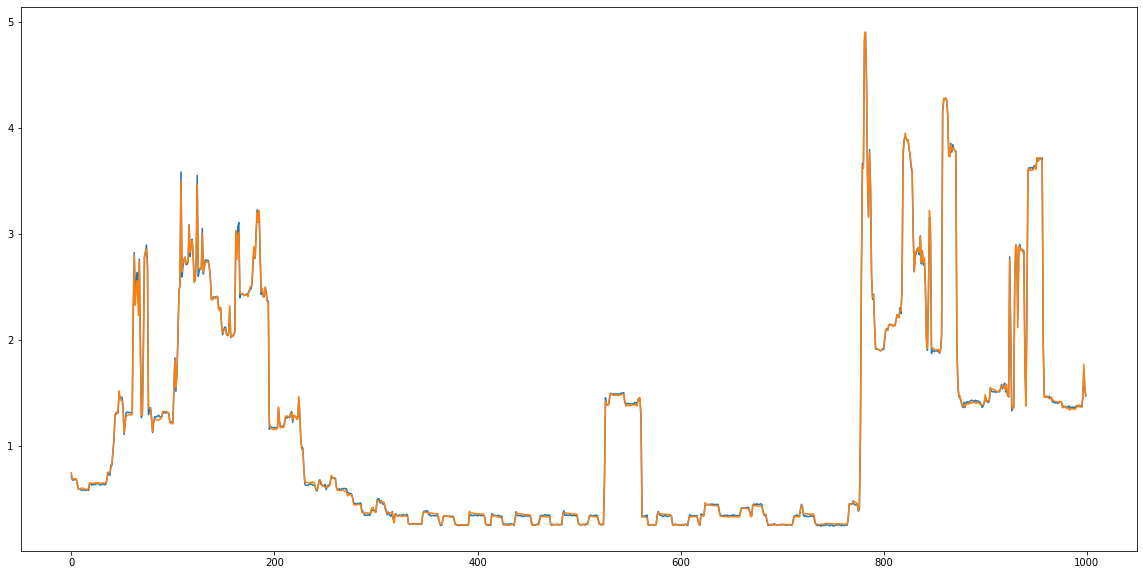

Test:  0.0007201322273098727
Iter:  1 loss:  0.00017297697906511626
Iter:  2 loss:  0.00017620027729052
Iter:  3 loss:  0.0002506099792176151
Iter:  4 loss:  0.0003473396666483564
Iter:  5 loss:  0.0003599560655170866
Iter:  6 loss:  0.00030476160416908246
Iter:  7 loss:  0.00030032836075698753
Iter:  8 loss:  0.00028630095273100473
Iter:  9 loss:  0.00024670311875883764


In [36]:
for e in range(10):
    train_loss = 0
    for batch_context_x, batch_context_y, batch_target_x, batch_target_y in train_loader:
        batch_context_x = batch_context_x.cuda()
        batch_context_y = batch_context_y.cuda()
        batch_target_x = batch_target_x.cuda()
        batch_target_y = batch_target_y.cuda()
        opt.zero_grad()
        preds, kl, loss, std = model(batch_context_x, batch_context_y, batch_target_x, batch_target_y)
        loss.backward()
        train_loss += loss.item()*256
        opt.step()
    print("Iter: ", e, "loss: ", train_loss/len(X_context_train))
    if e % 10 == 0:
        pred = []
        true = []
        with torch.no_grad():
            test_loss = 0
            for batch_context_x, batch_context_y, batch_target_x, batch_target_y in test_loader:
                batch_context_x = batch_context_x.cuda()
                batch_context_y = batch_context_y.cuda()
                batch_target_x = batch_target_x.cuda()
                batch_target_y = batch_target_y.cuda()
                preds, kl, loss, std = model(batch_context_x, batch_context_y, batch_target_x, None)
                mse_test = mse_loss(preds, batch_target_y)
                test_loss += mse_test.item()
                pred.append(preds.detach().cpu().numpy())
                true.append(batch_target_y.detach().cpu().numpy())
            pred = np.concatenate(pred)
            true = np.concatenate(true)
            pred = pred*(y_target_max - y_target_min) + y_target_min
            true = true*(y_target_max - y_target_min) + y_target_min
            mse = mean_squared_error(true[:, -1, 0, 0], pred[:, -1, 0, 0])
        plt.figure(figsize=(20, 10))
        plt.plot(pred[:1000, -1, 0, 0])
        plt.plot(true[:1000, -1, 0, 0])
        plt.show()
        print("Test: ", mse)